In [ ]:
import random
import numpy as np
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import torch
import cv2

image_processor = AutoImageProcessor.from_pretrained("yujunwei04/unsam-whole-image-segmentation")
model = Mask2FormerForUniversalSegmentation.from_pretrained("yujunwei04/unsam-whole-image-segmentation")

# specify the path here if you want to try your own images
image_path = "../docs/demos/sa_527160.jpg"
image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

inputs = image_processor(
    image_bgr,
    return_tensors="pt",
    do_resize=True,
    size={"shortest_edge": 1024, "longest_edge": 2048},
)

with torch.no_grad():
    outputs = model(**inputs)


You have 421 masks for this image


100%|██████████| 421/421 [00:35<00:00, 11.79it/s]


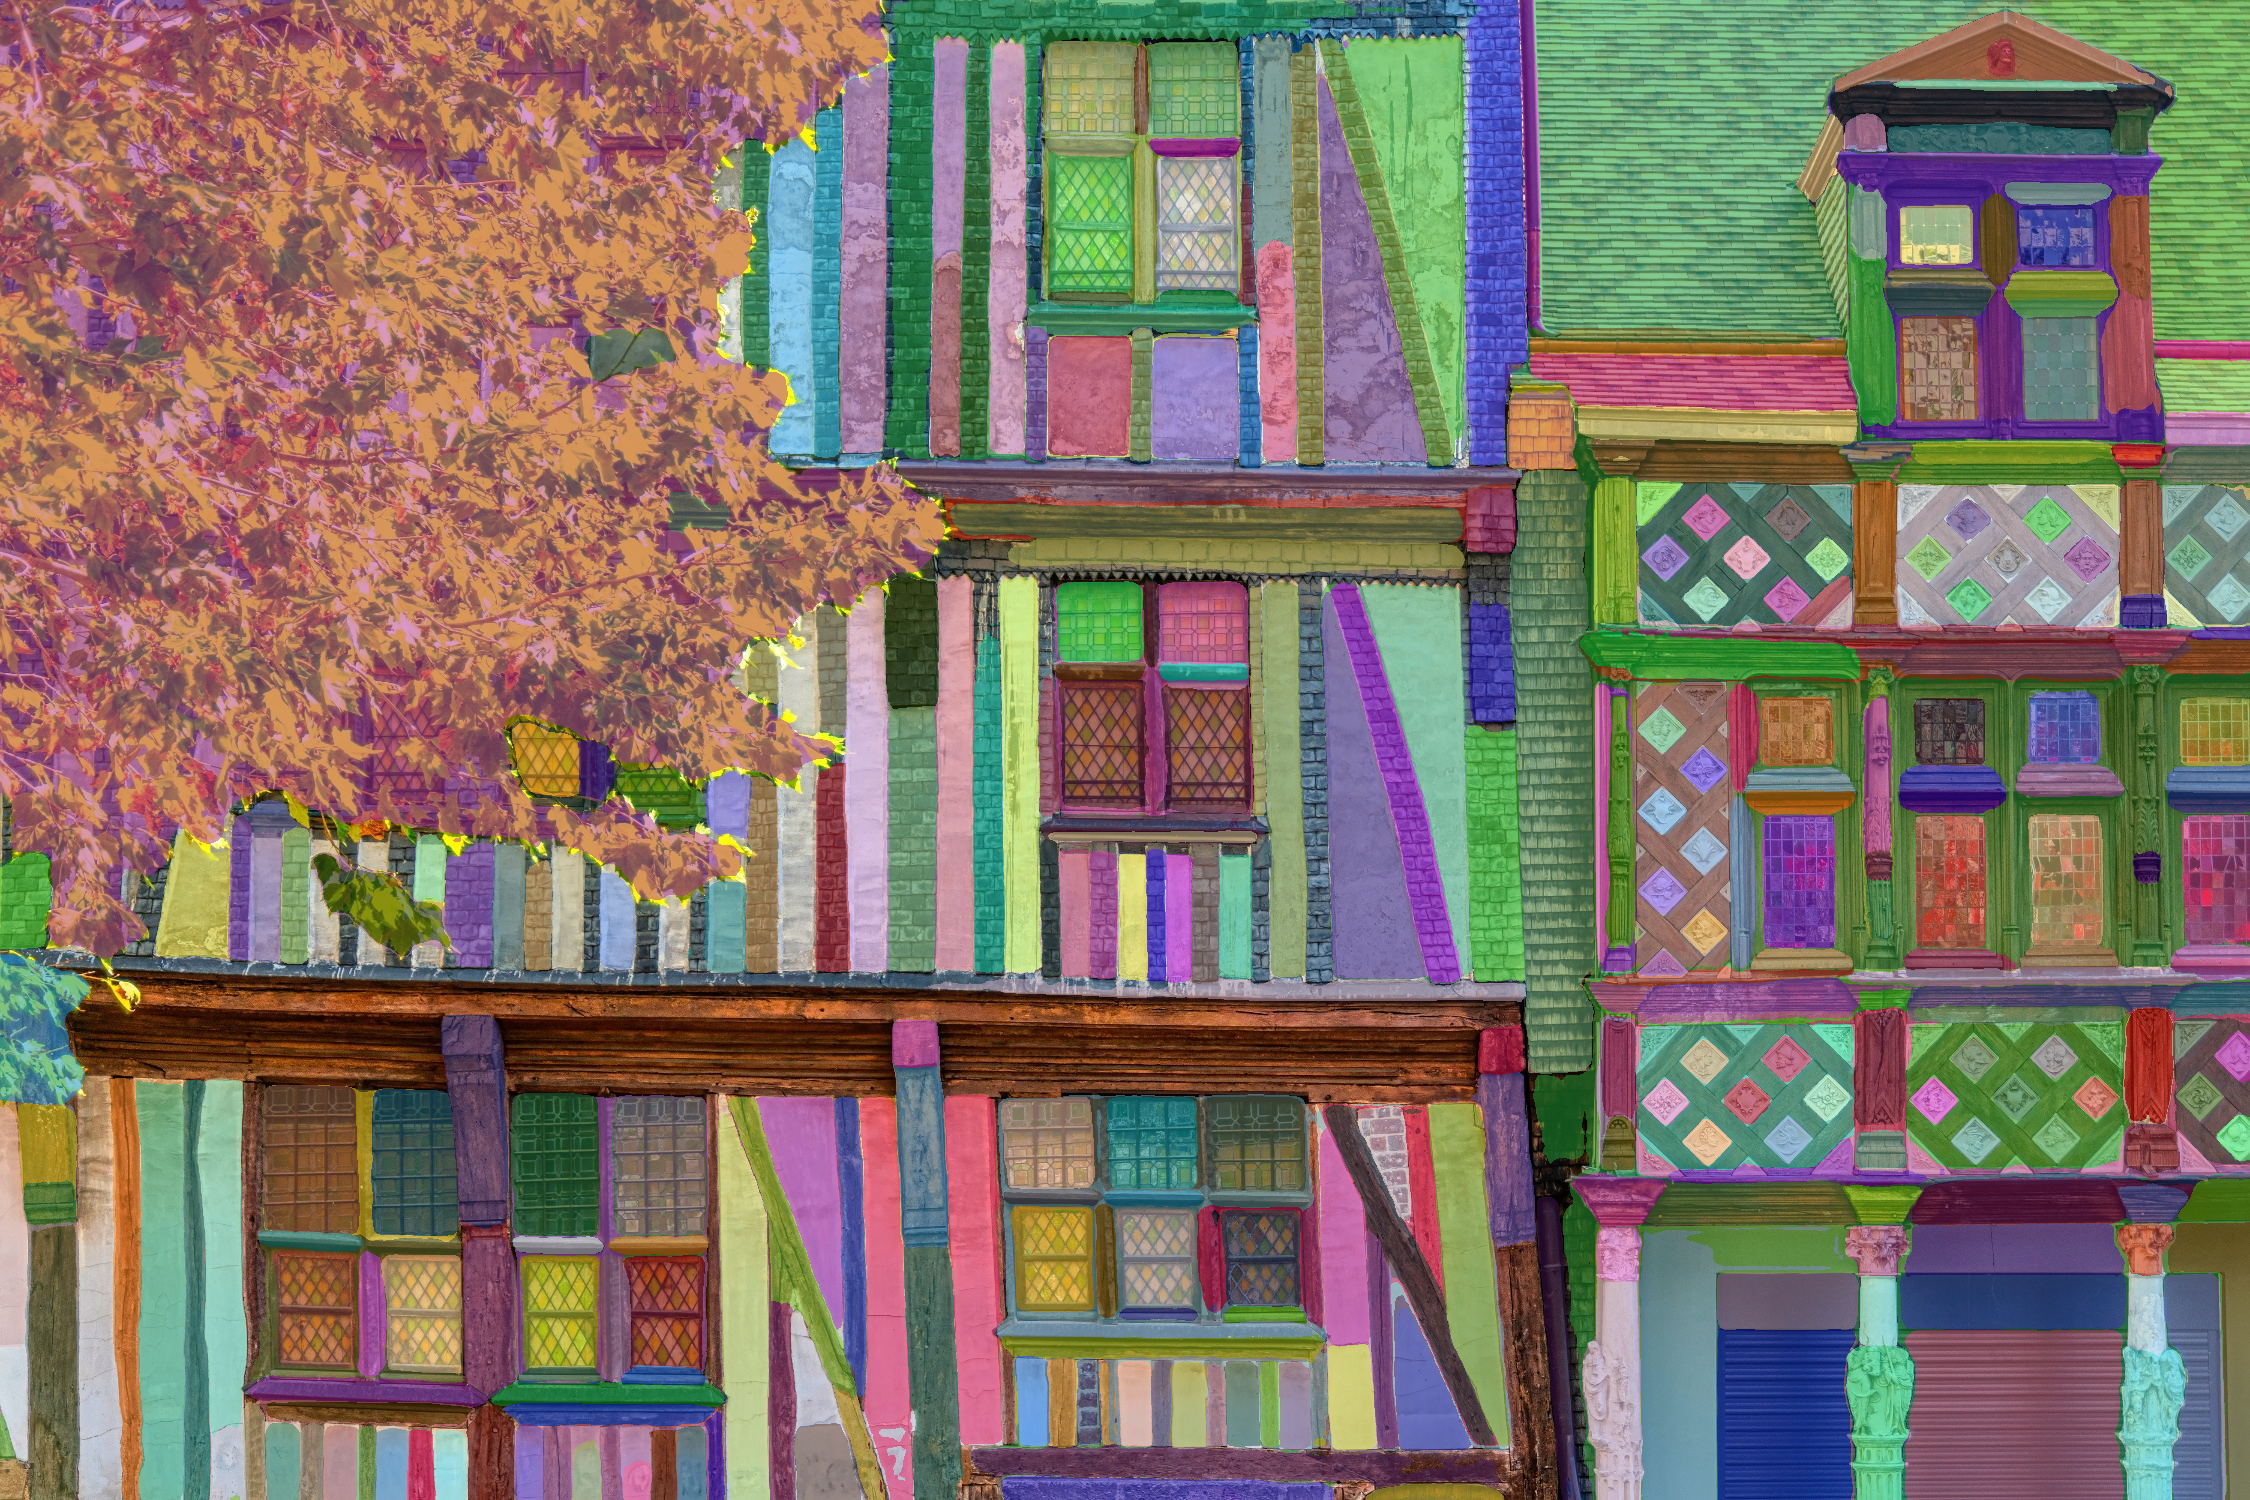

In [4]:
import torch
import numpy as np
from tqdm.auto import tqdm
from IPython.display import display

def area(mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
    return float(mask.sum())

def random_color(rgb=False):
    color = np.random.randint(0, 255, size=3)
    if rgb:
        return color.tolist()
    return tuple(color.tolist())

def vis_mask(input_image, mask, mask_color):
    mask = mask.astype(np.float32)
    if mask.ndim == 3:
        mask = mask[0]
    fg = mask > 0.5
    rgb = np.array(input_image).copy()
    rgb[fg] = (rgb[fg] * 0.5 + np.array(mask_color) * 0.5).astype(np.uint8)
    return Image.fromarray(rgb)

def show_image(input_image, mask_pool):
    if len(mask_pool) == 0:
        display(Image.fromarray(input_image))
        return
    already_painted = np.zeros(np.array(input_image).shape[:2], dtype=np.uint8)
    current = input_image.copy()
    for mask in tqdm(mask_pool):
        mask_arr = mask.astype(np.uint8)
        already_painted += mask_arr
        overlap = already_painted == 2
        if np.any(overlap):
            overlap = overlap.astype(bool)
            blended = overlap[:, :, None] * np.array(input_image) + (~overlap)[:, :, None] * np.array(current)
            current = Image.fromarray(blended.astype(np.uint8))
            already_painted -= overlap.astype(np.uint8)
        current = vis_mask(current, mask_arr, random_color(rgb=True))
    display(current)

mask_logits = outputs.masks_queries_logits
proc_h, proc_w = inputs.pixel_values.shape[-2:]
mask_logits = torch.nn.functional.interpolate(
    mask_logits, size=(proc_h, proc_w), mode="bilinear", align_corners=False
)
mask_probs = mask_logits.sigmoid()

target_h, target_w = image_rgb.shape[:2]
mask_probs = torch.nn.functional.interpolate(
    mask_probs, size=(target_h, target_w), mode="bilinear", align_corners=False
)

class_probs = outputs.class_queries_logits.softmax(dim=-1)[..., :-1]
mask_binary = mask_probs > 0.5
mask_scores = (mask_probs * mask_binary).flatten(2).sum(-1) / (
    mask_binary.flatten(2).sum(-1) + 1e-6
)
query_scores, query_labels = class_probs.max(dim=-1)
final_scores = query_scores * mask_scores

keep = final_scores[0] > 0.5
selected_masks = mask_probs[0, keep]
selected_scores = final_scores[0, keep]

if selected_masks.numel() == 0:
    sorted_masks = []
    sorted_scores = []
else:
    areas = selected_masks.flatten(1).sum(dim=1)
    order = torch.argsort(areas, descending=True)
    sorted_masks = (selected_masks[order] > 0.5).detach().cpu().numpy().astype(np.uint8)
    sorted_scores = selected_scores[order].detach().cpu().numpy()

print(f"You have {len(sorted_masks)} masks for this image")

show_image(image_rgb, sorted_masks)
